<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/weekly_CovidCases_CA_NY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic: Investigate Covid-19 NY and CA data

Each state in United States mandates Mask from a particular date for all places, only in business or only in public places where social distancing is not possible. We would like to investigate the impact on reduction or increase in Covid-19 cases due to this rule. 

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=a697d55fea7db897ad169bc9cfa7e06136d3608fd0e1a0517d68dd01d61b75d0
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Import Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import wget
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Mount Google drive


In [ ]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!ls /content/drive/My\ Drive/MasterProject-Personal/data

ls: cannot access '/content/drive/My Drive/MasterProject-Personal/data': No such file or directory


# Data Load

## 1 Load County Population


In [ ]:
county_population_US = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv',low_memory=False)
print(county_population_US.shape)

(3195, 4)


In [ ]:
wget.download('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv')
county_population_US = pd.read_csv('covid_county_population_usafacts.csv',low_memory=False)
print(county_population_US.shape)




(3195, 4)


In [ ]:
county_population_US.head(2)

,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869


## 2 Load Covid-19 case details (until July 12)

In [ ]:
!ls '/content/drive/My Drive/MasterProject-Personal/data/'

ls: cannot access '/content/drive/My Drive/MasterProject-Personal/data/': No such file or directory


### Note about data:
John Hopkins university updates data every day hence we are pulling from repository directly

**US Confirmed url** :https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv

**US deaths url**: https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv

In [ ]:
urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv',
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv']

[wget.download(url) for url in urls]        

['time_series_covid19_confirmed_US.csv', 'time_series_covid19_deaths_US.csv']

In [ ]:
confirmed_US = pd.read_csv('time_series_covid19_confirmed_US.csv',low_memory=False)
death_US = pd.read_csv('time_series_covid19_deaths_US.csv',low_memory=False)
print(confirmed_US.shape)
print(death_US.shape)
print(confirmed_US.head(2))
death_US.head(2)

(3340, 216)
(3340, 217)
        UID iso2 iso3  code3  ...  8/10/20 8/11/20 8/12/20 8/13/20
0  84001001   US  USA    840  ...     1174    1162    1188    1196
1  84001003   US  USA    840  ...     3651    3670    3710    3744

[2 rows x 216 columns]


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",55869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12,12,12,12,13,14,14,15,15,17,18,19,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,21,21,21,21,21,21,22,22,22
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",223234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9,9,9,9,10,11,11,11,11,11,12,13,13,14,14,14,15,15,16,17,17,17,17,17,20,20,21,21,22,23,23,23,23,23,24,25,25,29,29,29


In [ ]:
#print(len(mask_data['state_name'].unique()))
print(len(confirmed_US['Province_State'].unique()))
confirmed_US['Province_State'].unique()

58


array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'Diamond Princess', 'District of Columbia', 'Florida', 'Georgia',
       'Grand Princess', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Northern Mariana Islands', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virgin Islands', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

## 3 .Load Non-Pharmaceutical Interventions (NPIs) county level data

NPIs Include:
* SDO - Social Distancing of vulnerable persons;
* SD - Social Distancing of the general population;
* GS_XX - Gathering Size limitations;
* CPV - Closure of Public Venues;
* PC - Closure of schools and universities;
* NESC - Non-Essential Services Closure;
* LD - Lock Down (pending);

Link: 
1. https://www.keystonestrategy.com/coronavirus-covid19-intervention-dataset-model/
2. https://github.com/Keystone-Strategy/covid19-intervention-data
3. https://medium.com/@henrike.steimer/what-works-against-the-spread-of-covid-19-c0ecd4888386

In [ ]:
import wget
wget.download('https://raw.githubusercontent.com/Keystone-Strategy/covid19-intervention-data/master/complete_npis_inherited_policies.csv')




'complete_npis_inherited_policies.csv'

In [ ]:
data_NPI = pd.read_csv('complete_npis_inherited_policies.csv',low_memory=False)
print(data_NPI.shape)

(7389, 10)


In [ ]:
data_NPI.head(1).T

,0
fips,1
county,NaN
state,Alabama
npi,closing_of_public_venues
start_date,3/28/2020
end_date,5/11/2020
citation,http://www.alabamapublichealth.gov/news/2020/0...
note,3/19/20 order only for restaurants to do take ...
re-opening_note,NaN
re-opening_citation,NaN


## 4 Load US_County-level_Summaries

* **counties.csv**: contains demographic, socioeconomic, health care, education and transit data for each county in the 50 states and Washington DC. Note that this also includes analogous data for states, as available.

* **interventions.csv**: contains the dates that counties (or states governing them) took measures to mitigate the spread by restricting gatherings, given as the proleptic Gregorian ordinal of the date, where January 1 of year 1 has t = 1. 
It has now been updated to include intervention rollbacks. Any type of restaurant or gym reopening was taken as the rollback date (ex. the county could have reopened at 25% capacity and only outdoor, all the way to business as usual)

Link:
https://github.com/JieYingWu/COVID-19_US_County-level_Summaries/tree/master/data

In [ ]:
wget.download('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv')
data_county_summary = pd.read_csv('counties.csv',low_memory=False)
print(data_county_summary.shape)

(3273, 347)


In [ ]:
data_county_summary.dtypes

FIPS                                 int64
State                               object
Area_Name                           object
Rural-urban_Continuum Code_2013    float64
Urban_Influence_Code_2013          float64
                                    ...   
Number of AGGRAVATED ASSAULTS      float64
BURGLRY                            float64
LARCENY                            float64
MOTOR VEHICLE THEFTS               float64
ARSON                              float64
Length: 347, dtype: object

In [ ]:
data_county_summary.head(1).T

,0
FIPS,0
State,US
Area_Name,United States
Rural-urban_Continuum Code_2013,NaN
Urban_Influence_Code_2013,NaN
...,...
Number of AGGRAVATED ASSAULTS,NaN
BURGLRY,NaN
LARCENY,NaN
MOTOR VEHICLE THEFTS,NaN


In [ ]:
data_county_summary[data_county_summary['State']=='CA'].shape

(59, 347)

In [ ]:
wget.download('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/interventions.csv')
data_county_interventions = pd.read_csv('interventions.csv',low_memory=False)
print(data_county_interventions.shape)

(3273, 16)


In [ ]:
data_county_interventions[data_county_interventions['STATE']=='CA'].head(5)

,FIPS,STATE,AREA_NAME,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,stay at home rollback,>50 gatherings rollback,>500 gatherings rollback,restaurant dine-in rollback,entertainment/gym rollback
191,6000,CA,california,737503.0,737503.0,737503.0,737503.0,737499.0,737499.0,737500.0,737495.0,737554.0,NaN,NaN,737554.0,737554.0
192,6001,CA,alameda county,737503.0,737503.0,737503.0,737503.0,737499.0,737499.0,737500.0,737495.0,737554.0,NaN,NaN,737594.0,737554.0
193,6003,CA,alpine county,737503.0,737503.0,737503.0,737503.0,737499.0,737499.0,737500.0,737495.0,737558.0,737558.0,NaN,737558.0,737558.0
194,6005,CA,amador county,737503.0,737503.0,737503.0,737503.0,737499.0,737499.0,737500.0,737495.0,737558.0,737558.0,NaN,737558.0,737558.0
195,6007,CA,butte county,737503.0,737503.0,737503.0,737503.0,737499.0,737499.0,737500.0,737495.0,737558.0,737558.0,NaN,737558.0,737558.0


In [ ]:
data_county_interventions[data_county_interventions['STATE']=='CA'].shape


(59, 16)

## 5 Social Distancing Metrics

Link: 
1. https://docs.safegraph.com/docs/social-distancing-metrics#section-schema
2. https://www.safegraph.com/dashboard/covid19-shelter-in-place?s=US&d=07-25-2020&t=counties&m=index
3. https://docs.google.com/spreadsheets/d/1UNWvPzkUTTlXBZ6M6iGhM_7sr8h-MxsZdE7iOszkAmk/edit#gid=0

## 6 Lockdown data- govt strict policy index from Oxford

- https://github.com/OxCGRT/covid-policy-tracker

In [ ]:
url = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
wget.download(url)




'OxCGRT_latest.csv'

In [ ]:
data_policy = pd.read_csv('OxCGRT_latest.csv',low_memory=False)
print(data_policy.shape)

(38306, 42)


In [ ]:
data_policy.head(2)

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Aruba,ABW,20200101,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,20200102,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_policy[data_policy['CountryCode'] == 'USA']

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
35738,United States,USA,20200101,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0
35739,United States,USA,20200102,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0
35740,United States,USA,20200103,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0
35741,United States,USA,20200104,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0
35742,United States,USA,20200105,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35947,United States,USA,20200728,3.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,3.0,1.0,0.0,NaN,NaN,4290263.0,148011.0,68.98,68.98,68.57,68.57,NaN,68.91,70.08,70.08,NaN,62.5
35948,United States,USA,20200729,3.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,3.0,1.0,0.0,NaN,NaN,4351997.0,149256.0,68.98,68.98,68.57,68.57,NaN,68.91,70.08,70.08,NaN,62.5
35949,United States,USA,20200730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4426982.0,150713.0,NaN,68.98,NaN,68.57,NaN,68.91,NaN,70.08,NaN,62.5
35950,United States,USA,20200731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.98,NaN,68.57,NaN,68.91,NaN,70.08,NaN,62.5


## 7 Google mobility data

In [ ]:
wget.download('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=94537edba4db1128')



'Global_Mobility_Report.csv'

In [ ]:
mobility_data = pd.read_csv('Global_Mobility_Report.csv',low_memory=False)
mobility_data.head(2)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0


In [ ]:
mobility_data['country_region'].unique()

array(['United Arab Emirates', 'Afghanistan', 'Antigua and Barbuda',
       'Angola', 'Argentina', 'Austria', 'Australia', 'Aruba',
       'Bosnia and Herzegovina', 'Barbados', 'Bangladesh', 'Belgium',
       'Burkina Faso', 'Bulgaria', 'Bahrain', 'Benin', 'Bolivia',
       'Brazil', 'The Bahamas', 'Botswana', 'Belarus', 'Belize', 'Canada',
       'Switzerland', "Côte d'Ivoire", 'Chile', 'Cameroon', 'Colombia',
       'Costa Rica', 'Cape Verde', 'Czechia', 'Germany', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Estonia', 'Egypt', 'Spain',
       'Finland', 'Fiji', 'France', 'Gabon', 'United Kingdom', 'Georgia',
       'Ghana', 'Greece', 'Guatemala', 'Guinea-Bissau', 'Hong Kong',
       'Honduras', 'Croatia', 'Haiti', 'Hungary', 'Indonesia', 'Ireland',
       'Israel', 'India', 'Iraq', 'Italy', 'Jamaica', 'Jordan', 'Japan',
       'Kenya', 'Kyrgyzstan', 'Cambodia', 'South Korea', 'Kuwait',
       'Kazakhstan', 'Laos', 'Lebanon', 'Liechtenstein', 'Sri Lanka',
       'Lithuania', '

In [ ]:
US_mobility = mobility_data[mobility_data['country_region'] == 'United States']
US_mobility.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
910970,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
910971,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
910972,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
910973,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
910974,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0


## Data cleaning

In [ ]:
confirmed_US.columns[:11]

# Note: the first 11 columns contains UID, ios2,ios3, code ,FIPS, 'Admin2', 'Province_State',
      # 'Country_Region', 'Lat', 'Long_',Combined_Key', 'Population',


Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key'],
      dtype='object')

In [ ]:
# date begins from 11th column
confirmed_dates = confirmed_US.columns[11:]
confirmed_dates

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '8/4/20', '8/5/20', '8/6/20', '8/7/20', '8/8/20', '8/9/20', '8/10/20',
       '8/11/20', '8/12/20', '8/13/20'],
      dtype='object', length=205)

In [ ]:
death_US.columns[:12]

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Population'],
      dtype='object')

In [ ]:
death_US.columns[10:]

Index(['Combined_Key', 'Population', '1/22/20', '1/23/20', '1/24/20',
       '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       ...
       '8/4/20', '8/5/20', '8/6/20', '8/7/20', '8/8/20', '8/9/20', '8/10/20',
       '8/11/20', '8/12/20', '8/13/20'],
      dtype='object', length=207)

In [ ]:
death_dates = death_US.columns[12:]
death_dates

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '8/4/20', '8/5/20', '8/6/20', '8/7/20', '8/8/20', '8/9/20', '8/10/20',
       '8/11/20', '8/12/20', '8/13/20'],
      dtype='object', length=205)

#### Note: both the date values has the same beginning date 1/22/2020. Hence we can use either of the values

In [ ]:
confirmed_df_long = confirmed_US.melt(
    id_vars=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key'],
       value_vars=confirmed_dates,
       var_name = 'Date',
       value_name = 'Confirmed'
)

death_df_long = death_US.melt(
    id_vars=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Population'],
       value_vars=death_dates,
       var_name = 'Date',
       value_name = 'Deaths'
)

In [ ]:
confirmed_df_long.tail(10)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Confirmed
684690,84056029,US,USA,840,56029.0,Park,Wyoming,US,44.521575,-109.585283,"Park, Wyoming, US",8/13/20,139
684691,84056031,US,USA,840,56031.0,Platte,Wyoming,US,42.132991,-104.966331,"Platte, Wyoming, US",8/13/20,6
684692,84056033,US,USA,840,56033.0,Sheridan,Wyoming,US,44.790489,-106.886239,"Sheridan, Wyoming, US",8/13/20,74
684693,84056035,US,USA,840,56035.0,Sublette,Wyoming,US,42.765583,-109.913092,"Sublette, Wyoming, US",8/13/20,40
684694,84056037,US,USA,840,56037.0,Sweetwater,Wyoming,US,41.659439,-108.882788,"Sweetwater, Wyoming, US",8/13/20,267
684695,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",8/13/20,375
684696,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",8/13/20,278
684697,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,"Unassigned, Wyoming, US",8/13/20,0
684698,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",8/13/20,86
684699,84056045,US,USA,840,56045.0,Weston,Wyoming,US,43.839612,-104.567488,"Weston, Wyoming, US",8/13/20,5


In [ ]:
death_df_long.tail(10)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,Date,Deaths
684690,84056029,US,USA,840,56029.0,Park,Wyoming,US,44.521575,-109.585283,"Park, Wyoming, US",29194,8/13/20,0
684691,84056031,US,USA,840,56031.0,Platte,Wyoming,US,42.132991,-104.966331,"Platte, Wyoming, US",8393,8/13/20,0
684692,84056033,US,USA,840,56033.0,Sheridan,Wyoming,US,44.790489,-106.886239,"Sheridan, Wyoming, US",30485,8/13/20,0
684693,84056035,US,USA,840,56035.0,Sublette,Wyoming,US,42.765583,-109.913092,"Sublette, Wyoming, US",9831,8/13/20,0
684694,84056037,US,USA,840,56037.0,Sweetwater,Wyoming,US,41.659439,-108.882788,"Sweetwater, Wyoming, US",42343,8/13/20,0
684695,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",23464,8/13/20,0
684696,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",20226,8/13/20,0
684697,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,"Unassigned, Wyoming, US",0,8/13/20,29
684698,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",7805,8/13/20,0
684699,84056045,US,USA,840,56045.0,Weston,Wyoming,US,43.839612,-104.567488,"Weston, Wyoming, US",6927,8/13/20,0


## Check California-New York data

In [ ]:
state= ['California','New York']
confirmed_CA_df = confirmed_df_long[confirmed_df_long['Province_State'].isin(state)]
confirmed_CA_df.tail(5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Confirmed
683319,84036115,US,USA,840,36115.0,Washington,New York,US,43.311538,-73.430434,"Washington, New York, US",8/13/20,260
683320,84036117,US,USA,840,36117.0,Wayne,New York,US,43.154944,-77.029765,"Wayne, New York, US",8/13/20,263
683321,84036119,US,USA,840,36119.0,Westchester,New York,US,41.162784,-73.757417,"Westchester, New York, US",8/13/20,36357
683322,84036121,US,USA,840,36121.0,Wyoming,New York,US,42.701451,-78.221996,"Wyoming, New York, US",8/13/20,118
683323,84036123,US,USA,840,36123.0,Yates,New York,US,42.635055,-77.103699,"Yates, New York, US",8/13/20,58


## Merging Confirmed and Death data

In [ ]:
full_table = confirmed_df_long.merge(
    right=death_df_long,
    how='left',
    on=[ 'UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key','Date']
)

full_table.head(10)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Confirmed,Population,Deaths
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",1/22/20,0,55869,0
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",1/22/20,0,223234,0
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",1/22/20,0,24686,0
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",1/22/20,0,22394,0
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",1/22/20,0,57826,0
5,84001011,US,USA,840,1011.0,Bullock,Alabama,US,32.100305,-85.712655,"Bullock, Alabama, US",1/22/20,0,10101,0
6,84001013,US,USA,840,1013.0,Butler,Alabama,US,31.753001,-86.680575,"Butler, Alabama, US",1/22/20,0,19448,0
7,84001015,US,USA,840,1015.0,Calhoun,Alabama,US,33.774837,-85.826304,"Calhoun, Alabama, US",1/22/20,0,113605,0
8,84001017,US,USA,840,1017.0,Chambers,Alabama,US,32.913601,-85.390727,"Chambers, Alabama, US",1/22/20,0,33254,0
9,84001019,US,USA,840,1019.0,Cherokee,Alabama,US,34.178060,-85.606390,"Cherokee, Alabama, US",1/22/20,0,26196,0


In [ ]:
#full_table['Date'] = pd.to_datetime(full_table['Date'])


In [ ]:
ship_data = full_table['Province_State'].str.contains('Grand Princess') | full_table['Province_State'].str.contains('Diamond Princess') | full_table['Province_State'].str.contains('Northern Mariana Islands') | full_table['Province_State'].str.contains('American Samoa') |full_table['Province_State'].str.contains('Guam') | full_table['Province_State'].str.contains('Virgin Islands')

full_ship = full_table[ship_data]


In [ ]:
# Removing ship data from State data

full_table = full_table[~(ship_data)]

## Group data

In [ ]:
full_grouped = full_table.groupby(['Date', 'Province_State','FIPS'])['Confirmed', 'Deaths'].sum().reset_index()

full_grouped.tail(5)

,Date,Province_State,FIPS,Confirmed,Deaths
681415,8/9/20,Wyoming,56041.0,278,0
681416,8/9/20,Wyoming,56043.0,77,0
681417,8/9/20,Wyoming,56045.0,5,0
681418,8/9/20,Wyoming,80056.0,0,0
681419,8/9/20,Wyoming,90056.0,0,27


In [ ]:
full_grouped.shape

(624912, 5)

####  Adding new cases, new deaths by subtracting from previous day record

In [ ]:
# new cases 
temp = full_grouped.groupby(['Province_State', 'Date', ])['Confirmed', 'Deaths']
temp = temp.sum().diff().reset_index()
mask = temp['Province_State'] != temp['Province_State'].shift(1)
temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan

# renaming columns
temp.columns = ['Province_State', 'Date', 'New cases', 'New deaths']
# merging new values
full_grouped = pd.merge(full_grouped, temp, on=['Province_State', 'Date'])
# filling na with 0
full_grouped = full_grouped.fillna(0)
# fixing data types
cols = ['New cases', 'New deaths']
full_grouped[cols] = full_grouped[cols].astype('int')
# 
full_grouped['New cases'] = full_grouped['New cases'].apply(lambda x: 0 if x<0 else x)

In [ ]:
full_grouped.tail(5)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
681415,8/9/20,Wyoming,56041.0,278,0,35,0
681416,8/9/20,Wyoming,56043.0,77,0,35,0
681417,8/9/20,Wyoming,56045.0,5,0,35,0
681418,8/9/20,Wyoming,80056.0,0,0,35,0
681419,8/9/20,Wyoming,90056.0,0,27,35,0


In [ ]:
state= ['California','New York']
ca_df = full_grouped[full_grouped['Province_State'].isin(state)]
ca_df.head(10)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
194,1/22/20,California,6001.0,0,0,0,0
195,1/22/20,California,6003.0,0,0,0,0
196,1/22/20,California,6005.0,0,0,0,0
197,1/22/20,California,6007.0,0,0,0,0
198,1/22/20,California,6009.0,0,0,0,0
199,1/22/20,California,6011.0,0,0,0,0
200,1/22/20,California,6013.0,0,0,0,0
201,1/22/20,California,6015.0,0,0,0,0
202,1/22/20,California,6017.0,0,0,0,0
203,1/22/20,California,6019.0,0,0,0,0


In [ ]:
ca_df.to_csv('CA-Clean-data.csv')

In [ ]:
county_population_US.head(2)

,countyFIPS,County Name,State,population,FIPS
0,0,Statewide Unallocated,AL,0,0
1,1001,Autauga County,AL,55869,1001


In [ ]:
county_population_US['FIPS'] = county_population_US['countyFIPS']

In [ ]:
ca_df.shape

(25420, 7)

In [ ]:
11160 - 10788

372

# Merge with FIPS 

In [ ]:
merged = pd.merge(ca_df,county_population_US,how='inner' ,on=['FIPS'])
print(merged.shape)

(24600, 11)


In [ ]:
merged.tail(2)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,countyFIPS,County Name,State,population
24598,8/8/20,New York,36123.0,56,7,703,8,36123,Yates County,NY,24913
24599,8/9/20,New York,36123.0,57,7,515,6,36123,Yates County,NY,24913


## Visualization

# Latent Variables

## Latent variable 1 - Weekly growth

In [ ]:
merged.dtypes

Date               object
Province_State     object
FIPS              float64
Confirmed           int64
Deaths              int64
New cases           int64
New deaths          int64
countyFIPS          int64
County Name        object
State              object
population          int64
dtype: object

In [ ]:
def fixDate(x):
  arr = x.split('/')
  m = arr[0]
  d = arr[1]
  y = arr[2]

  if int(m) < 10:
    m = '0'+str(m)
  if int(d) < 10:
    d = '0'+str(d)
  return m+'/'+d+'/'+y

In [ ]:
fixDate('1/22/20')

'01/22/20'

In [ ]:
merged['Date'] = merged['Date'].apply(lambda x: fixDate(x))
merged.head(2)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,countyFIPS,County Name,State,population
0,01/22/20,California,6001.0,0,0,0,0,6001,Alameda County,CA,1671329
1,01/23/20,California,6001.0,0,0,0,0,6001,Alameda County,CA,1671329


In [ ]:
minDate = merged['Date'].min()
print(minDate)
maxDate = merged['Date'].max()
maxDate
dateList = merged['Date'].unique()
print(len(dateList))

dateList.sort()
#print(dateList)

01/22/20
188


In [ ]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%m/%d/%y').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

3


In [ ]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 7 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  index = index+j
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  
  print(row)
  lst.append(row)
  # if count > 5:
  #   break


[1, '01/22/20', '01/25/20']
[2, '01/26/20', '02/01/20']
[3, '02/02/20', '02/08/20']
[4, '02/09/20', '02/15/20']
[5, '02/16/20', '02/22/20']
[6, '02/23/20', '02/29/20']
[7, '03/01/20', '03/07/20']
[8, '03/08/20', '03/14/20']
[9, '03/15/20', '03/21/20']
[10, '03/22/20', '03/28/20']
[11, '03/29/20', '04/04/20']
[12, '04/05/20', '04/11/20']
[13, '04/12/20', '04/18/20']
[14, '04/19/20', '04/25/20']
[15, '04/26/20', '05/02/20']
[16, '05/03/20', '05/09/20']
[17, '05/10/20', '05/16/20']
[18, '05/17/20', '05/23/20']
[19, '05/24/20', '05/30/20']
[20, '05/31/20', '06/06/20']
[21, '06/07/20', '06/13/20']
[22, '06/14/20', '06/20/20']
[23, '06/21/20', '06/27/20']
[24, '06/28/20', '07/04/20']
[25, '07/05/20', '07/11/20']
[26, '07/12/20', '07/18/20']
[27, '07/19/20', '07/25/20']
[28, '07/26/20', '07/27/20']


In [ ]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head(2)

,WeekNumber,startDate,endDate
0,1,01/22/20,01/25/20
1,2,01/26/20,02/01/20


In [ ]:
merged.head(1)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,countyFIPS,County Name,State,population
0,01/22/20,California,6001.0,0,0,0,0,6001,Alameda County,CA,1671329


In [ ]:
week_df['Date'] = week_df['startDate']

In [ ]:
start_date_df = (
    merged
    .merge(week_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"Confirmed": "start_date_Confirmed"})
    .reset_index(drop=True)

    [['County Name', 'population', 'start_date_Confirmed','startDate','WeekNumber']]
    .pivot_table(values='start_date_Confirmed', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

In [ ]:
merged[(merged['Date'] == '05/06/20') & (merged['County Name'] == 'Yuba County')] #16, '05/06/20', '05/12/20'

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,countyFIPS,County Name,State,population
10843,05/06/20,California,6115.0,19,1,2160,83,6115,Yuba County,CA,78668


In [ ]:
merged[(merged['Date'] == '05/12/20') & (merged['County Name'] == 'Yuba County')]

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,countyFIPS,County Name,State,population
10819,05/12/20,California,6115.0,23,1,1651,100,6115,Yuba County,CA,78668


In [ ]:
start_date_df.tail(1).T

,57
County Name,Yuba County
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [ ]:
week_df['Date'] = week_df['endDate']

In [ ]:
end_date_df = (
    merged
    .merge(week_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"Confirmed": "end_date_Confirmed"})
    .reset_index(drop=True)

    [['County Name', 'population', 'end_date_Confirmed','endDate','WeekNumber']]
    .pivot_table(values='end_date_Confirmed', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

In [ ]:
end_date_df.tail(1).T

,57
County Name,Yuba County
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [ ]:
weekList = week_df['WeekNumber'].unique()
weekList

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [ ]:
# merging 2012-2017 data with 2018 data
agg_start_date_df = (
    start_date_df
    # .merge(first_date_2018_df, on='ticker', how='inner')
    # .rename(columns=({2018: "2018"}))
    .melt(id_vars='County Name', value_vars=weekList)
    .rename(columns={"variable": "WeekNumber", "value": "startDateCount"})
)

agg_end_date_df = (
    end_date_df
    # .merge(last_date_2018_df, on='ticker', how='inner')
    # .rename(columns=({2018: "2018"}))
    .melt(id_vars='County Name', value_vars=weekList)
    .rename(columns={"variable": "WeekNumber", "value": "endDateCount"})
)

In [ ]:
agg_start_date_df.tail()

,County Name,WeekNumber,startDateCount
1619,Tulare County,28,8210
1620,Tuolumne County,28,126
1621,Ventura County,28,6392
1622,Yolo County,28,1394
1623,Yuba County,28,372


In [ ]:
agg_end_date_df.tail(2)

,County Name,WeekNumber,endDateCount
1622,Yolo County,28,1424
1623,Yuba County,28,382


In [ ]:
agg_start_date_df[(agg_start_date_df['County Name'] == 'Yuba County') & (agg_start_date_df['WeekNumber'] == 16)]

,County Name,WeekNumber,startDateCount
927,Yuba County,16,19


In [ ]:
agg_end_date_df[(agg_end_date_df['County Name'] == 'Yuba County') & (agg_end_date_df['WeekNumber'] == 16)]

,County Name,WeekNumber,endDateCount
927,Yuba County,16,20


In [ ]:
agg_gains_df = (
    agg_start_date_df
    .merge(agg_end_date_df, on=['County Name', 'WeekNumber'], how='inner')
    .pipe(lambda x: x.assign(increased_cases=x.endDateCount-x.startDateCount))
    .pipe(lambda x: x.assign(gains_pctg=x.increased_cases/x.startDateCount))
    .groupby(['County Name', 'WeekNumber'])
    .agg({"gains_pctg": "mean"})
    .reset_index()
    .rename(columns={"gains_pctg": "weekly_growth"})
)

In [ ]:
agg_gains_df.tail(5)

,County Name,WeekNumber,weekly_growth
1619,Yuba County,24,0.630769
1620,Yuba County,25,0.698113
1621,Yuba County,26,0.312500
1622,Yuba County,27,0.385214
1623,Yuba County,28,0.026882


##  Latent Variable 2 & 3 - Weekly variance and Percent change in Weekly data

In [ ]:
def overall_change(arr, N): 
    result = 0; 
  
    var1 = arr[0]; 
    var2 = arr[1]; 
    
    # Calculate successive change of 1st 2 change 
    result = float(var1 + var2 + 
            (float(var1 * var2) / 100)); 
  
    # Calculate successive change 
    # for rest of the value 
    for i in range(2, N): 
        result = (result + arr[i] +
                 (float(result * arr[i]) / 100)); 
        
    return result; 

In [ ]:
lst = []
for county in merged['County Name'].unique():
  #print('county ',county)
  for i in range(0,week_df.shape[0]):
    row=[]
    #print(week_df['startDate'][i])
    #print(merged[(merged['County Name'] == county) & (merged['Date'] >= week_df['startDate'][i]) & (merged['Date'] <= week_df['endDate'][i])])
    confirmed_cases = merged[(merged['County Name'] == county) & (merged['Date'] >= week_df['startDate'][i]) & (merged['Date'] <= week_df['endDate'][i])]['Confirmed'].to_list()
 
    #print(confirmed_cases)
    if len(confirmed_cases) > 1:
      row.append(county)
      row.append(week_df['WeekNumber'][i])
      row.append(np.var(confirmed_cases))
      row.append(overall_change(confirmed_cases, len(confirmed_cases)))
      lst.append(row)

    #break

In [ ]:
weekly_var_df = pd.DataFrame(lst,index=None,columns=['County Name','WeekNumber','WeeklyVariance','PercentChange'])
weekly_var_df.tail(2)

,County Name,WeekNumber,WeeklyVariance,PercentChange
1622,Yuba County,27,889.428571,1.943995e+06
1623,Yuba County,28,25.000000,2.175040e+03


In [ ]:
print(agg_gains_df.shape)
agg_gains_df.dtypes

(1624, 3)


County Name       object
WeekNumber         int64
weekly_growth    float64
dtype: object

In [ ]:
print(weekly_var_df.shape)
weekly_var_df.dtypes
agg_gains_df.head()

(1624, 4)


,County Name,WeekNumber,weekly_growth
0,Alameda County,1,NaN
1,Alameda County,2,NaN
2,Alameda County,3,NaN
3,Alameda County,4,NaN
4,Alameda County,5,NaN


In [ ]:
agg_df3 = pd.merge(agg_gains_df,weekly_var_df,how='inner' ,on=['County Name','WeekNumber'])


In [ ]:
agg_df3.tail(5)

,County Name,WeekNumber,weekly_growth,WeeklyVariance,PercentChange
1619,Yuba County,24,0.630769,273.673469,7.845792e+03
1620,Yuba County,25,0.698113,536.244898,5.512087e+04
1621,Yuba County,26,0.312500,489.673469,3.731792e+05
1622,Yuba County,27,0.385214,889.428571,1.943995e+06
1623,Yuba County,28,0.026882,25.000000,2.175040e+03


### Concate merged and latent variables

In [ ]:
print(agg_df3.shape)
print(merged.shape)
concatenated_df.shape

(1624, 5)
(10904, 11)


(305312, 15)

In [ ]:
x =agg_df3.copy()
x

,County Name,WeekNumber,weekly_growth,WeeklyVariance,PercentChange
0,Alameda County,1,NaN,0.000000,0.000000e+00
1,Alameda County,2,NaN,0.000000,0.000000e+00
2,Alameda County,3,NaN,0.000000,0.000000e+00
3,Alameda County,4,NaN,0.000000,0.000000e+00
4,Alameda County,5,NaN,0.000000,0.000000e+00
...,...,...,...,...,...
1619,Yuba County,24,0.630769,273.673469,7.845792e+03
1620,Yuba County,25,0.698113,536.244898,5.512087e+04
1621,Yuba County,26,0.312500,489.673469,3.731792e+05
1622,Yuba County,27,0.385214,889.428571,1.943995e+06


In [ ]:
df.apply(np.sum, axis 

In [ ]:
x['population'] = agg_df3['County Name'].apply(lambda x: print(x))


Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alameda County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Alpine County
Amador County
Amador County
Amador County
Amador County
Amador County
Amador County
Amador County
Amador County
Amador County
Amador County
Amador County
Amador County
Amador County
Amador

In [ ]:
concatenated_df = pd.merge(merged,agg_df3, how='inner',on='County Name')
concatenated_df.head(2)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,countyFIPS,County Name,State,population,WeekNumber,weekly_growth,WeeklyVariance,PercentChange
0,01/22/20,California,6001.0,0,0,0,0,6001,Alameda County,CA,1671329,1,NaN,0.0,0.0
1,01/22/20,California,6001.0,0,0,0,0,6001,Alameda County,CA,1671329,2,NaN,0.0,0.0


In [ ]:
agg_df3.head(20)

,County Name,WeekNumber,weekly_growth,WeeklyVariance,PercentChange
0,Alameda County,1,NaN,0.000000,0.000000e+00
1,Alameda County,2,NaN,0.000000,0.000000e+00
2,Alameda County,3,NaN,0.000000,0.000000e+00
3,Alameda County,4,NaN,0.000000,0.000000e+00
4,Alameda County,5,NaN,0.000000,0.000000e+00
5,Alameda County,6,NaN,0.000000,0.000000e+00
6,Alameda County,7,inf,0.408163,6.141609e+00
7,Alameda County,8,4.500000,8.857143,4.032108e+01
8,Alameda County,9,5.181818,316.775510,6.419970e+02
9,Alameda County,10,2.098592,2599.265306,5.850479e+04


## Replace inf to nan

In [ ]:
agg_df4 = agg_df3.replace([np.inf, -np.inf], np.nan)
agg_df4.head(12)

,County Name,WeekNumber,weekly_growth,WeeklyVariance,PercentChange
0,Alameda County,1,NaN,0.000000,0.000000e+00
1,Alameda County,2,NaN,0.000000,0.000000e+00
2,Alameda County,3,NaN,0.000000,0.000000e+00
3,Alameda County,4,NaN,0.000000,0.000000e+00
4,Alameda County,5,NaN,0.000000,0.000000e+00
5,Alameda County,6,NaN,0.000000,0.000000e+00
6,Alameda County,7,NaN,0.408163,6.141609e+00
7,Alameda County,8,4.500000,8.857143,4.032108e+01
8,Alameda County,9,5.181818,316.775510,6.419970e+02
9,Alameda County,10,2.098592,2599.265306,5.850479e+04


In [ ]:
# clean na data before clustering
agg_df4['weekly_growth'] = agg_df4['weekly_growth'].fillna(0)
agg_df4['WeeklyVariance'] = agg_df4['WeeklyVariance'].fillna(0)
agg_df4['PercentChange'] = agg_df4['PercentChange'].fillna(0)

In [ ]:
agg_df4.tail(5)

,County Name,WeekNumber,weekly_growth,WeeklyVariance,PercentChange
1619,Yuba County,24,0.630769,273.673469,7.845792e+03
1620,Yuba County,25,0.698113,536.244898,5.512087e+04
1621,Yuba County,26,0.312500,489.673469,3.731792e+05
1622,Yuba County,27,0.385214,889.428571,1.943995e+06
1623,Yuba County,28,0.026882,25.000000,2.175040e+03


# County name Encoding

In [ ]:
agg_df4["County Name"] = agg_df4["County Name"].astype('category')
agg_df4["county_name_category"] = agg_df4["County Name"].cat.codes

In [ ]:
data1 = agg_df4#agg_df4.drop('County Name', axis =1)

# Clustering

##K-means clustering - Function

In [ ]:
def kmeans_cluster(data_to_fit, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data_to_fit)
    cluster_indices = kmeans.predict(data_to_fit)
    return cluster_indices

   

In [ ]:
def kmeans_plot(data_to_fit,cluster_indices):
   fig, ax = plt.subplots()
   scatter = ax.scatter(data_to_fit[:,0],data_to_fit[:,1], s=150,marker='o',edgecolors='black' ,c = cluster_indices, cmap ="rainbow")

   # produce a legend with the unique colors from the scatter
   legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters")
   ax.add_artist(legend1)
   plt.title('K-Means Clustering') 
   plt.gcf().set_size_inches(22,8)
   plt.show()


1. Combination1: 'weekly_growth' and 'weeklyVariance'
2. Combination2: WeeklyVariance and PercentChange
3. Combination3: 'PercentChange' and 'weekly_growth'

In [ ]:
data1.tail(5)

,County Name,WeekNumber,weekly_growth,WeeklyVariance,PercentChange,county_name_category
1619,Yuba County,24,0.630769,273.673469,7.845792e+03,57
1620,Yuba County,25,0.698113,536.244898,5.512087e+04,57
1621,Yuba County,26,0.312500,489.673469,3.731792e+05,57
1622,Yuba County,27,0.385214,889.428571,1.943995e+06,57
1623,Yuba County,28,0.026882,25.000000,2.175040e+03,57


In [ ]:
data1_comb1 = data1.filter(['County Name','WeekNumber','weekly_growth','WeeklyVariance','county_name_category'], axis=1)
data1_comb2 = data1.filter(['County Name','WeekNumber','WeeklyVariance','PercentChange','county_name_category'], axis=1)
data1_comb3 = data1.filter(['County Name','WeekNumber','PercentChange','weekly_growth','county_name_category'], axis=1)

In [ ]:
merged.dtypes

Date               object
Province_State     object
FIPS              float64
Confirmed           int64
Deaths              int64
New cases           int64
New deaths          int64
countyFIPS          int64
County Name        object
State              object
population          int64
dtype: object

In [ ]:
print(data1_comb1.shape)
print(data1_comb2.shape)
print(data1_comb3.shape)

(1624, 5)
(1624, 5)
(1624, 5)


## GMM - Function

In [ ]:
def gmm_cluster(data_to_fit,n_clusters):
  print('gmm')
  gmm = GaussianMixture(n_components=n_clusters, max_iter=50).fit(data_to_fit)
  labels = gmm.predict(data_to_fit)
  gmm_scores = gmm.score_samples(data_to_fit)

  print('Means by sklearn:\n', gmm.means_)
  #print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
  print('Scores by sklearn:\n', gmm_scores[0:20])
  #print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])

  fig, ax = plt.subplots()
  scatter = ax.scatter(data_to_fit[:,0],data_to_fit[:,1], s=150,marker='o',edgecolors='black' ,c = labels, cmap ="rainbow")
   # produce a legend with the unique colors from the scatter
  legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters")
  ax.add_artist(legend1)
  plt.title('GMM Clustering') 
  plt.gcf().set_size_inches(22,8)
  plt.show()


##Silhoutte score - Function

In [ ]:
def plot_cluster(df, max_loop=50):
    """
    Looking at the performance of various number of clusters using K-Means.
    Performance is evaluated by within cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    
    # robust scaling is used so that the centering and scaling statistics are therefore not influenced by a few number of very large marginal outliers as they are based on percentiles
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()

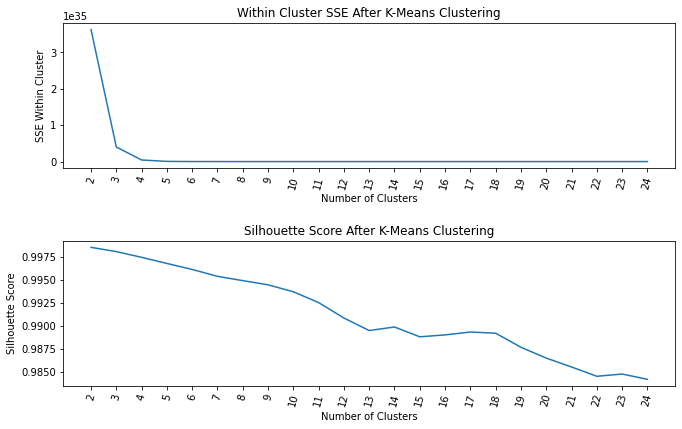

In [ ]:
plot_cluster(data1, max_loop=25)

In [ ]:
def apply_cluster(df, clusters=2):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10, n_jobs=-1)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(score.round(2)))
    print("sse withing cluster: " + str(sse_within_cluster.round()))
    
    return df

In [ ]:
first_trial = apply_cluster(data1, clusters=14)

clustering performance
-----------------------------------
silhouette score: 0.99
sse withing cluster: 1.6055665657301324e+25


## Fractal Clustering - Function

In [ ]:
def prep_final_data_to_fit(agg_df4):
    county_names = agg_df4['County Name'].values
    # Dropping stock_name from data to plot
    data_to_fit = agg_df4.copy().drop(['County Name', 'WeekNumber','county_name_category','cluster'], axis=1)
    print(data_to_fit)
    #data_to_fit = data_to_fit.copy().drop('cluster', axis=1)
    # Getting data as values for clustering algorithms
    data_to_fit = data_to_fit.values
    print (data_to_fit)
    return data_to_fit

### Combination1: 'weekly_growth' and 'weeklyVariance'


In [ ]:
def fractal_clustering_combo1(data, n_iterations =3,n_clusters=3):
  for i in range(n_iterations):

    plot_cluster(data, max_loop=25)
    first_trial = apply_cluster(data, clusters=n_clusters)
    cluster_perf_df = (
      first_trial
      .groupby('cluster')
      .agg({"weekly_growth":"max", "WeeklyVariance":"max", "County Name":"count","county_name_category":"count","WeekNumber":"count"})
      .sort_values('weekly_growth')
      .reset_index()
    )

    print(cluster_perf_df.head())
    # data = first_trial.query("cluster == 0").reset_index(drop=True)
    # print(data.head())
  
  return first_trial,cluster_perf_df

In [ ]:
data1_comb1.tail(5)

,County Name,WeekNumber,weekly_growth,WeeklyVariance,county_name_category
1619,Yuba County,24,0.630769,273.673469,57
1620,Yuba County,25,0.698113,536.244898,57
1621,Yuba County,26,0.312500,489.673469,57
1622,Yuba County,27,0.385214,889.428571,57
1623,Yuba County,28,0.026882,25.000000,57


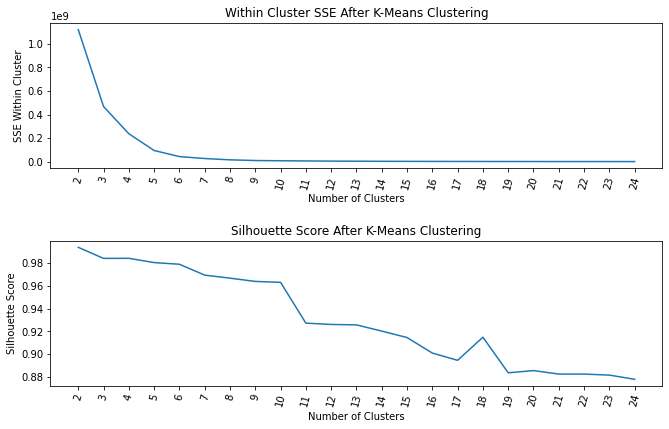

clustering performance
-----------------------------------
silhouette score: 0.98
sse withing cluster: 468023578.0
   cluster  weekly_growth  ...  county_name_category  WeekNumber
0        1       0.146785  ...                     3           3
1        2       0.680123  ...                    14          14
2        0      20.000000  ...                  1607        1607

[3 rows x 6 columns]


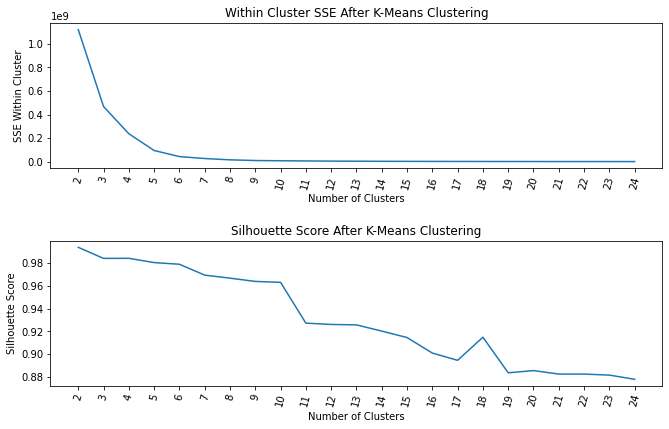

clustering performance
-----------------------------------
silhouette score: 0.98
sse withing cluster: 468023578.0
   cluster  weekly_growth  ...  county_name_category  WeekNumber
0        1       0.146785  ...                     3           3
1        2       0.680123  ...                    14          14
2        0      20.000000  ...                  1607        1607

[3 rows x 6 columns]


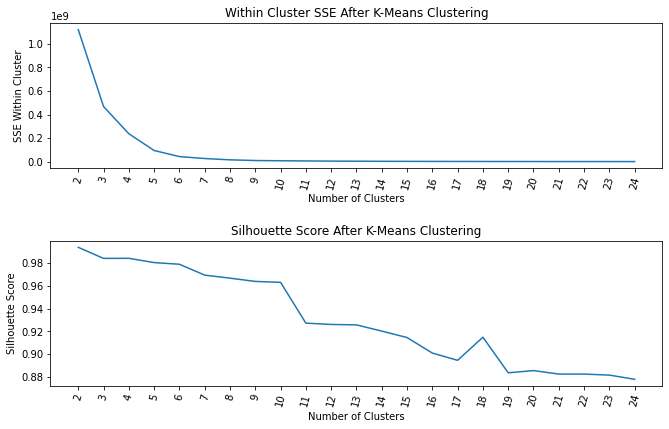

clustering performance
-----------------------------------
silhouette score: 0.98
sse withing cluster: 468023578.0
   cluster  weekly_growth  ...  county_name_category  WeekNumber
0        1       0.146785  ...                     3           3
1        2       0.680123  ...                    14          14
2        0      20.000000  ...                  1607        1607

[3 rows x 6 columns]


,cluster,weekly_growth,WeeklyVariance,County Name,county_name_category,WeekNumber
0,1,0.146785,4.531586e+07,3,3,3
1,2,0.680123,1.485140e+07,14,14,14
2,0,20.000000,2.877877e+06,1607,1607,1607


In [ ]:
fractalData_combo1,cluster_perf_df1_2 = fractal_clustering_combo1(data1_comb1,n_iterations=3)
cluster_perf_df1_2

###Note: 
After 3 iterations of fractal clustering for Weekly growth and Weekly variance, we got 3 clusters with format below


Cluster | Number of weekly county data
--- | ---
Cluster 0 | 1549
Cluster 1 | 3
Cluster 2 | 14

from the above dataframe, we can see 14 weekly county data has wide weekly variance and average weekly growth of 0.254958

In [ ]:
print(fractalData_combo1.shape)
print(fractalData_combo1.head(2))
fractalData_combo1.tail(2)

(1624, 6)
      County Name  WeekNumber  ...  county_name_category  cluster
0  Alameda County           1  ...                     0        0
1  Alameda County           2  ...                     0        0

[2 rows x 6 columns]


,County Name,WeekNumber,weekly_growth,WeeklyVariance,county_name_category,cluster
1622,Yuba County,27,0.385214,889.428571,57,0
1623,Yuba County,28,0.026882,25.000000,57,0


In [ ]:
final_data_combo1 = fractalData_combo1.query("cluster == 0").reset_index(drop=True)
print(final_data_combo1.shape)
final_data_combo1.tail(3)

(1607, 6)


,County Name,WeekNumber,weekly_growth,WeeklyVariance,county_name_category,cluster
1604,Yuba County,26,0.312500,489.673469,57,0
1605,Yuba County,27,0.385214,889.428571,57,0
1606,Yuba County,28,0.026882,25.000000,57,0


####  Checking how cluster2 with 14 weekly county forms K-means cluster

In [ ]:
combo1_cluster2 = fractalData_combo1.query("cluster == 2").reset_index(drop=True)
print(combo1_cluster2.shape)
combo1_cluster2

(14, 6)


,County Name,WeekNumber,weekly_growth,WeeklyVariance,county_name_category,cluster
0,Kern County,27,0.680123,3.940040e+06,14,2
1,Los Angeles County,14,0.550361,5.366142e+06,18,2
2,Los Angeles County,15,0.272244,3.448942e+06,18,2
3,Los Angeles County,16,0.215650,3.619044e+06,18,2
4,Los Angeles County,17,0.178437,3.812860e+06,18,2
5,Los Angeles County,18,0.160743,4.634935e+06,18,2
6,Los Angeles County,19,0.193905,8.079009e+06,18,2
7,Los Angeles County,20,0.134198,6.174150e+06,18,2
8,Los Angeles County,21,0.128642,7.977707e+06,18,2
9,Los Angeles County,22,0.119025,8.625595e+06,18,2


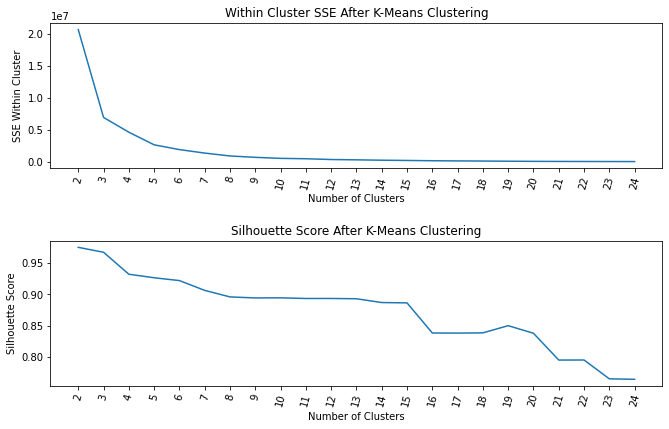

clustering performance
-----------------------------------
silhouette score: 0.93
sse withing cluster: 2671493.0


,County Name,WeekNumber,weekly_growth,WeeklyVariance,county_name_category,cluster
0,Alameda County,1,0.0,0.0,0,0
1,Alameda County,2,0.0,0.0,0,0
2,Alameda County,3,0.0,0.0,0,0
3,Alameda County,4,0.0,0.0,0,0
4,Alameda County,5,0.0,0.0,0,0


In [ ]:
plot_cluster(final_data_combo1, max_loop=25)
first_trial = apply_cluster(final_data_combo1, clusters=5)
final_data_combo1.head()

In [ ]:

test2 = final_data_combo1.query("cluster == 0").reset_index(drop=True)
print(test2.shape)

test2 = final_data_combo1.query("cluster == 1").reset_index(drop=True)
print(test2.shape)
test2


(1537, 6)
(4, 6)


,County Name,WeekNumber,weekly_growth,WeeklyVariance,county_name_category,cluster
0,Orange County,26,0.173822,2.222163e+06,29,1
1,Orange County,27,0.153844,2.479060e+06,29,1
2,Riverside County,27,0.166301,2.877877e+06,32,1
3,San Bernardino County,26,0.237515,2.566832e+06,35,1


In [ ]:
test2 = final_data_combo1.query("cluster == 2").reset_index(drop=True)
print(test2.shape)
print(test2['WeeklyVariance'].min())
print(test2['WeeklyVariance'].max())


print(test2['weekly_growth'].min())
print(test2['weekly_growth'].max())
test2



(16, 6)
496197.63265306124
1022291.918367347
0.01155634219645207
1.5177692728266812


,County Name,WeekNumber,weekly_growth,WeeklyVariance,county_name_category,cluster
0,Fresno County,27,0.262206,6.968586e+05,9,2
1,Los Angeles County,11,1.517769,9.575494e+05,18,2
2,Los Angeles County,12,0.419479,8.396697e+05,18,2
3,Los Angeles County,13,0.351585,1.022292e+06,18,2
4,Los Angeles County,28,0.011556,1.011030e+06,18,2
5,Orange County,23,0.195740,4.961976e+05,29,2
6,Riverside County,22,0.218112,6.102425e+05,32,2
7,Riverside County,23,0.224213,9.354073e+05,32,2
8,San Bernardino County,23,0.233071,6.373404e+05,35,2
9,San Bernardino County,24,0.189114,6.259259e+05,35,2


In [ ]:
test2 = final_data_combo1.query("cluster == 3").reset_index(drop=True)
print(test2.shape)
test2

(44, 6)


,County Name,WeekNumber,weekly_growth,WeeklyVariance,county_name_category,cluster
0,Alameda County,24,0.156261,105399.346939,0,3
1,Alameda County,25,0.126915,102007.836735,0,3
2,Alameda County,26,0.178373,198873.142857,0,3
3,Alameda County,27,0.118328,172107.673469,0,3
4,Contra Costa County,27,0.207635,171621.387755,6,3
5,Fresno County,23,0.378737,175612.000000,9,3
6,Fresno County,24,0.307778,231897.959184,9,3
7,Fresno County,25,0.293944,461020.244898,9,3
8,Fresno County,26,0.201884,333923.632653,9,3
9,Imperial County,20,0.571603,146514.530612,12,3


In [ ]:
test2 = final_data_combo1.query("cluster == 4").reset_index(drop=True)
print(test2.shape)
test2

(6, 6)


,County Name,WeekNumber,weekly_growth,WeeklyVariance,county_name_category,cluster
0,Orange County,24,0.284185,1.550231e+06,29,4
1,Riverside County,24,0.243368,1.794040e+06,32,4
2,Riverside County,26,0.158692,1.996717e+06,32,4
3,San Bernardino County,25,0.267390,1.921393e+06,35,4
4,San Bernardino County,27,0.127208,1.291477e+06,35,4
5,San Diego County,26,0.193227,1.377164e+06,36,4


In [ ]:
#final_data[['County Name','weekly_growth','WeeklyVariance']]
data_to_fit = prep_final_data_to_fit(final_data_combo1)

      weekly_growth  WeeklyVariance
0          0.000000        0.000000
1          0.000000        0.000000
2          0.000000        0.000000
3          0.000000        0.000000
4          0.000000        0.000000
...             ...             ...
1602       0.630769      273.673469
1603       0.698113      536.244898
1604       0.312500      489.673469
1605       0.385214      889.428571
1606       0.026882       25.000000

[1607 rows x 2 columns]
[[0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 ...
 [3.12500000e-01 4.89673469e+02]
 [3.85214008e-01 8.89428571e+02]
 [2.68817204e-02 2.50000000e+01]]


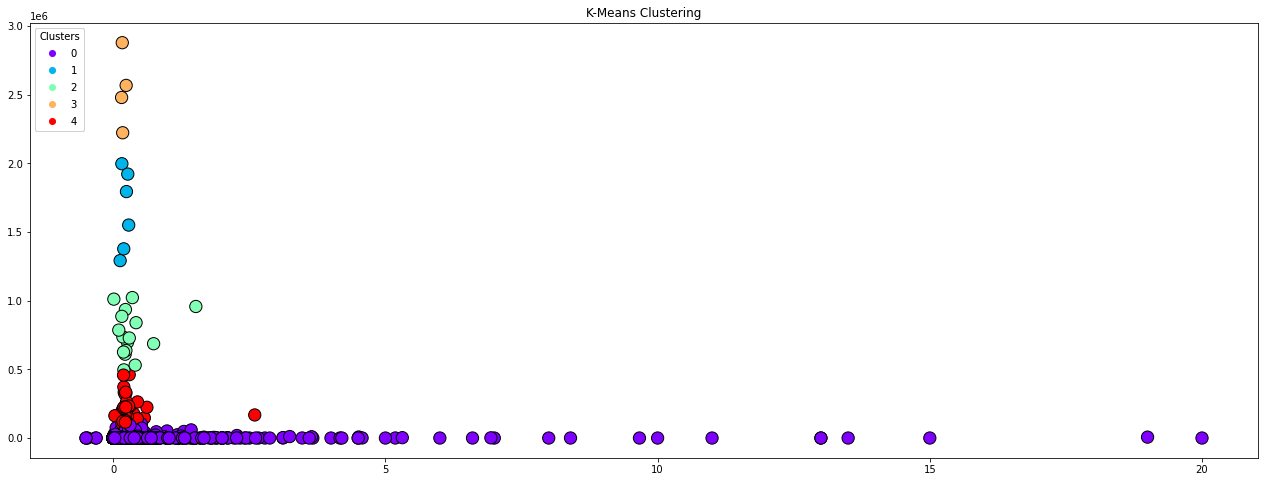

In [ ]:
n_clusters=5

cluster_indices=kmeans_cluster (data_to_fit, n_clusters)
kmeans_plot(data_to_fit,cluster_indices)

gmm
Means by sklearn:
 [[0.00000000e+00 0.00000000e+00]
 [3.78473315e+00 4.82575550e+04]
 [2.49989964e-01 7.26844961e+03]
 [2.05691438e-01 3.86131853e+05]
 [3.58915621e-01 3.49972552e+01]]
Scores by sklearn:
 [ 11.02684021  11.02684021  11.02684021  11.02684021  11.02684021
  11.02684021  -6.79976829 -18.17606531 -18.20403006 -18.28430142
 -13.38572579 -11.36692869 -10.95518698 -10.89571083 -11.00946528
 -11.00884472 -11.16737814 -11.28096904 -12.14710643 -11.72593871]


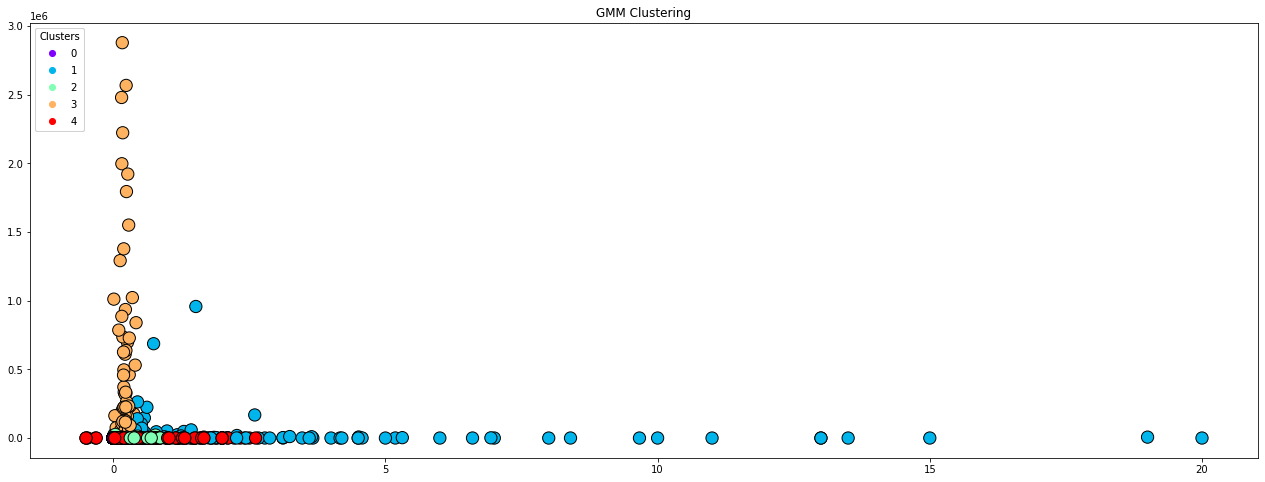

In [ ]:
gmm_cluster(data_to_fit, n_clusters)

### Combination2: WeeklyVariance and PercentChange


In [ ]:
def fractal_clustering_combo2(data, n_iterations =3,n_clusters=3):
  for i in range(n_iterations):

    plot_cluster(data, max_loop=25)
    first_trial = apply_cluster(data, clusters=n_clusters)
    cluster_perf_df = (
      first_trial
      .groupby('cluster')
      .agg({"WeeklyVariance":"mean", "PercentChange":"mean", "County Name":"count","county_name_category":"count","WeekNumber":"count"})
      .sort_values('WeeklyVariance')
      .reset_index()
    )

    print(cluster_perf_df.head())
    data = first_trial.query("cluster == 0").reset_index(drop=True)
    print(data.head())
  
  return first_trial,cluster_perf_df

In [ ]:
data1_comb2.tail(5)

,County Name,WeekNumber,WeeklyVariance,PercentChange,county_name_category
1619,Yuba County,24,273.673469,7.845792e+03,57
1620,Yuba County,25,536.244898,5.512087e+04,57
1621,Yuba County,26,489.673469,3.731792e+05,57
1622,Yuba County,27,889.428571,1.943995e+06,57
1623,Yuba County,28,25.000000,2.175040e+03,57


In [ ]:
data1_comb2.shape

(1624, 5)

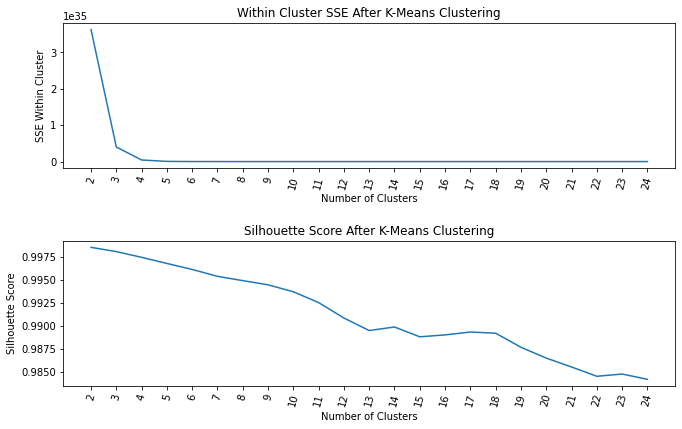

clustering performance
-----------------------------------
silhouette score: 1.0
sse withing cluster: 4.0071423350148713e+34
   cluster  WeeklyVariance  ...  county_name_category  WeekNumber
0        0    1.027225e+05  ...                  1622        1622
1        1    2.803374e+07  ...                     1           1
2        2    4.531586e+07  ...                     1           1

[3 rows x 6 columns]
      County Name  WeekNumber  ...  county_name_category  cluster
0  Alameda County           1  ...                     0        0
1  Alameda County           2  ...                     0        0
2  Alameda County           3  ...                     0        0
3  Alameda County           4  ...                     0        0
4  Alameda County           5  ...                     0        0

[5 rows x 6 columns]


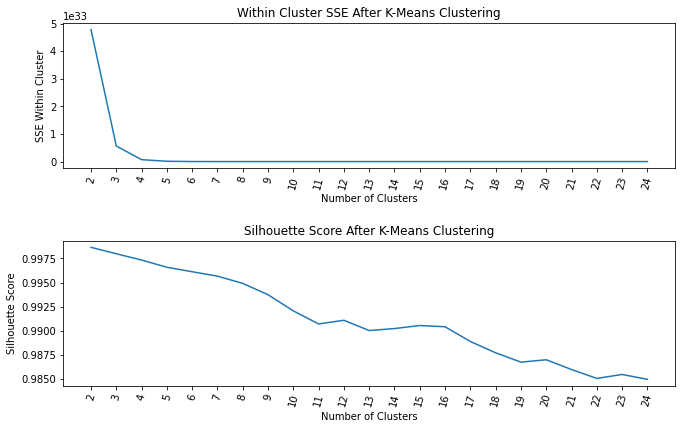

clustering performance
-----------------------------------
silhouette score: 1.0
sse withing cluster: 5.633915875527698e+32
   cluster  WeeklyVariance  ...  county_name_category  WeekNumber
0        0    7.834340e+04  ...                  1620        1620
1        2    1.292332e+07  ...                     1           1
2        1    2.677625e+07  ...                     1           1

[3 rows x 6 columns]
      County Name  WeekNumber  ...  county_name_category  cluster
0  Alameda County           1  ...                     0        0
1  Alameda County           2  ...                     0        0
2  Alameda County           3  ...                     0        0
3  Alameda County           4  ...                     0        0
4  Alameda County           5  ...                     0        0

[5 rows x 6 columns]


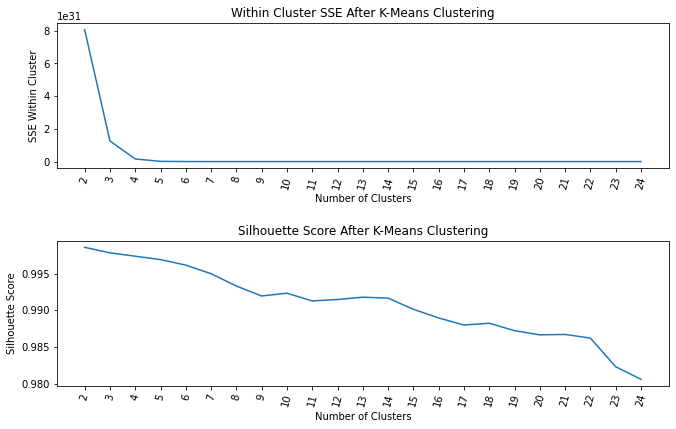

clustering performance
-----------------------------------
silhouette score: 1.0
sse withing cluster: 1.2582281616641637e+31
   cluster  WeeklyVariance  ...  county_name_category  WeekNumber
0        0    6.393035e+04  ...                  1618        1618
1        2    8.625595e+06  ...                     1           1
2        1    1.485140e+07  ...                     1           1

[3 rows x 6 columns]
      County Name  WeekNumber  ...  county_name_category  cluster
0  Alameda County           1  ...                     0        0
1  Alameda County           2  ...                     0        0
2  Alameda County           3  ...                     0        0
3  Alameda County           4  ...                     0        0
4  Alameda County           5  ...                     0        0

[5 rows x 6 columns]


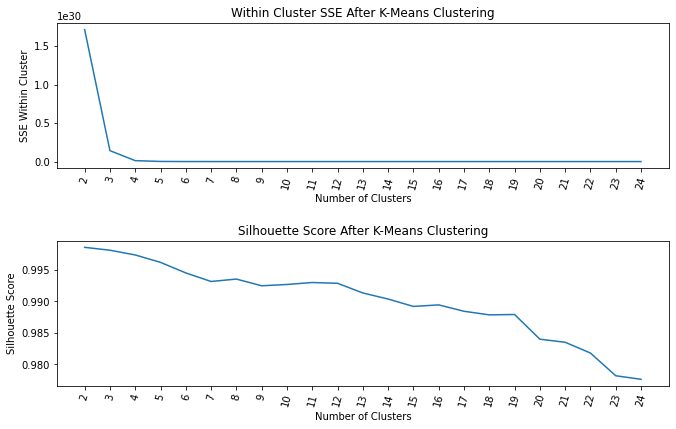

clustering performance
-----------------------------------
silhouette score: 1.0
sse withing cluster: 1.4208574852098816e+29
   cluster  WeeklyVariance  ...  county_name_category  WeekNumber
0        0    5.525214e+04  ...                  1616        1616
1        2    6.174150e+06  ...                     1           1
2        1    7.977707e+06  ...                     1           1

[3 rows x 6 columns]
      County Name  WeekNumber  ...  county_name_category  cluster
0  Alameda County           1  ...                     0        0
1  Alameda County           2  ...                     0        0
2  Alameda County           3  ...                     0        0
3  Alameda County           4  ...                     0        0
4  Alameda County           5  ...                     0        0

[5 rows x 6 columns]


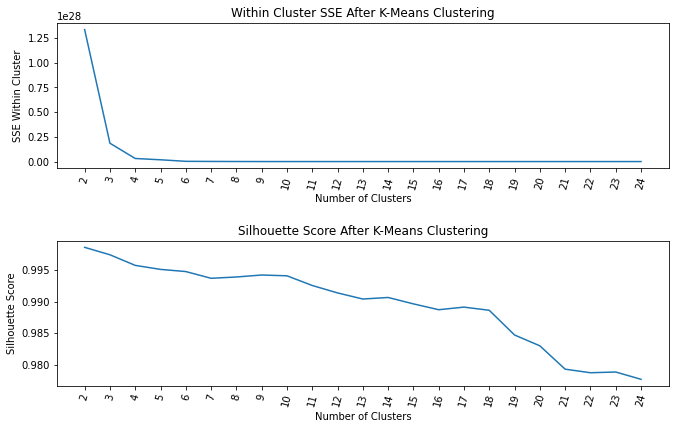

clustering performance
-----------------------------------
silhouette score: 1.0
sse withing cluster: 1.858063847083087e+27
   cluster  WeeklyVariance  ...  county_name_category  WeekNumber
0        0    4.744331e+04  ...                  1614        1614
1        2    4.634935e+06  ...                     1           1
2        1    8.079009e+06  ...                     1           1

[3 rows x 6 columns]
      County Name  WeekNumber  ...  county_name_category  cluster
0  Alameda County           1  ...                     0        0
1  Alameda County           2  ...                     0        0
2  Alameda County           3  ...                     0        0
3  Alameda County           4  ...                     0        0
4  Alameda County           5  ...                     0        0

[5 rows x 6 columns]


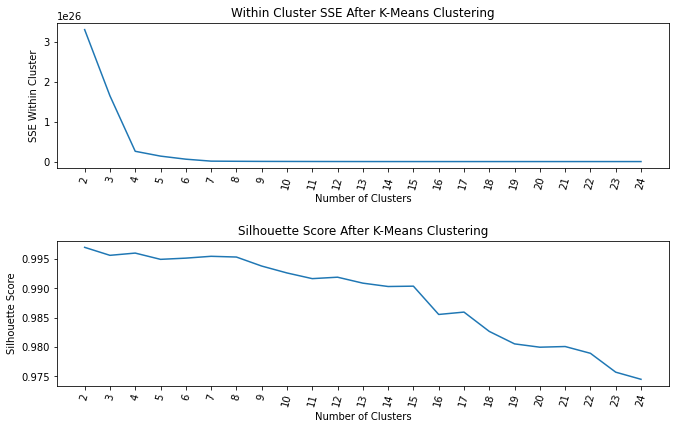

clustering performance
-----------------------------------
silhouette score: 1.0
sse withing cluster: 1.650074276862801e+26
   cluster  WeeklyVariance  ...  county_name_category  WeekNumber
0        0    3.579620e+04  ...                  1606        1606
1        2    1.983003e+06  ...                     5           5
2        1    3.056599e+06  ...                     3           3

[3 rows x 6 columns]
      County Name  WeekNumber  ...  county_name_category  cluster
0  Alameda County           1  ...                     0        0
1  Alameda County           2  ...                     0        0
2  Alameda County           3  ...                     0        0
3  Alameda County           4  ...                     0        0
4  Alameda County           5  ...                     0        0

[5 rows x 6 columns]


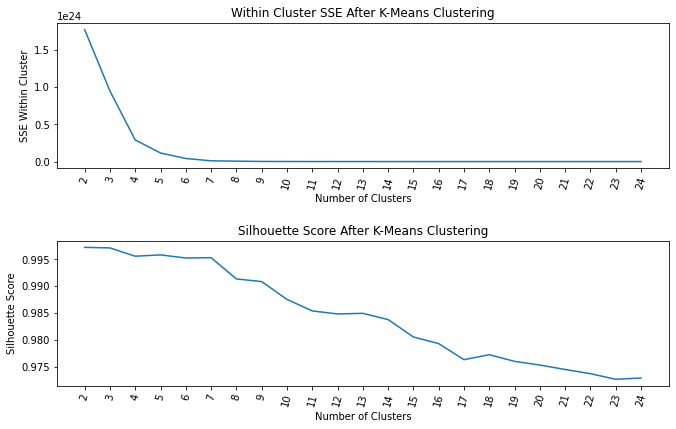

clustering performance
-----------------------------------
silhouette score: 1.0
sse withing cluster: 9.501927061008306e+23
   cluster  WeeklyVariance  ...  county_name_category  WeekNumber
0        0    2.543538e+04  ...                  1601        1601
1        1    3.203996e+06  ...                     3           3
2        2    3.577336e+06  ...                     2           2

[3 rows x 6 columns]
      County Name  WeekNumber  ...  county_name_category  cluster
0  Alameda County           1  ...                     0        0
1  Alameda County           2  ...                     0        0
2  Alameda County           3  ...                     0        0
3  Alameda County           4  ...                     0        0
4  Alameda County           5  ...                     0        0

[5 rows x 6 columns]


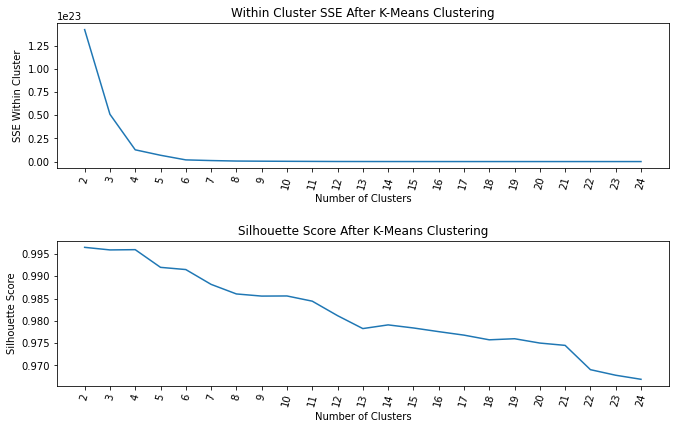

clustering performance
-----------------------------------
silhouette score: 1.0
sse withing cluster: 5.101557265732119e+22
   cluster  WeeklyVariance  ...  county_name_category  WeekNumber
0        0    1.727299e+04  ...                  1594        1594
1        1    1.339922e+06  ...                     2           2
2        2    2.101811e+06  ...                     5           5

[3 rows x 6 columns]
      County Name  WeekNumber  ...  county_name_category  cluster
0  Alameda County           1  ...                     0        0
1  Alameda County           2  ...                     0        0
2  Alameda County           3  ...                     0        0
3  Alameda County           4  ...                     0        0
4  Alameda County           5  ...                     0        0

[5 rows x 6 columns]


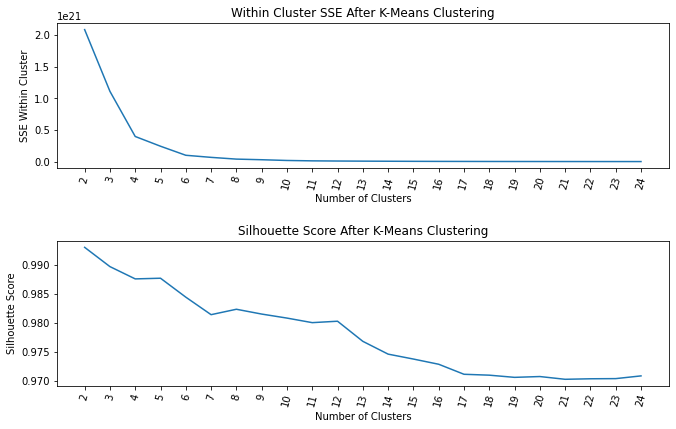

clustering performance
-----------------------------------
silhouette score: 0.99
sse withing cluster: 1.1108044394527418e+21
   cluster  WeeklyVariance  ...  county_name_category  WeekNumber
0        0    11604.284950  ...                  1583        1583
1        1   564749.374150  ...                     3           3
2        2   933663.729592  ...                     8           8

[3 rows x 6 columns]
      County Name  WeekNumber  ...  county_name_category  cluster
0  Alameda County           1  ...                     0        0
1  Alameda County           2  ...                     0        0
2  Alameda County           3  ...                     0        0
3  Alameda County           4  ...                     0        0
4  Alameda County           5  ...                     0        0

[5 rows x 6 columns]


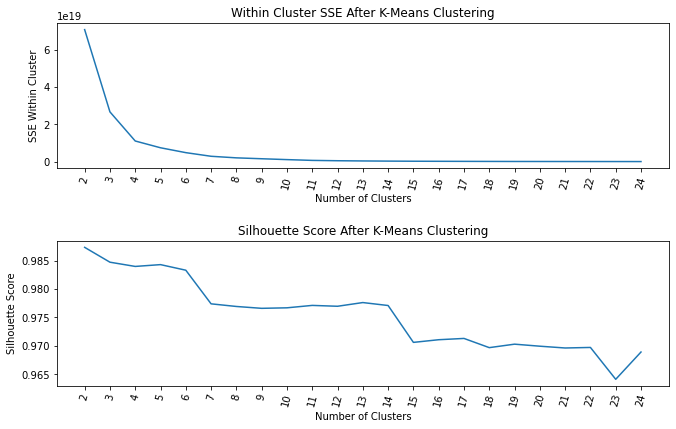

clustering performance
-----------------------------------
silhouette score: 0.98
sse withing cluster: 2.6726163234133148e+19
   cluster  WeeklyVariance  ...  county_name_category  WeekNumber
0        1     8824.266073  ...                  1564        1564
1        0   227267.801749  ...                    14          14
2        2   277336.342857  ...                     5           5

[3 rows x 6 columns]
          County Name  WeekNumber  ...  county_name_category  cluster
0      Alameda County          25  ...                     0        0
1      Alameda County          26  ...                     0        0
2     Imperial County          25  ...                    12        0
3     Imperial County          26  ...                    12        0
4  Los Angeles County          12  ...                    18        0

[5 rows x 6 columns]


,cluster,WeeklyVariance,PercentChange,County Name,county_name_category,WeekNumber
0,1,8824.266073,7.910056e+12,1564,1564,1564
1,0,227267.801749,1.951046e+15,14,14,14
2,2,277336.342857,5.161500e+15,5,5,5


In [ ]:
fractal_data_combo2,cluster_perf_df2 = fractal_clustering_combo2(data1_comb2,n_iterations=10)
cluster_perf_df2.head()

In [ ]:
cluster_perf_df2

,cluster,WeeklyVariance,PercentChange,County Name,county_name_category,WeekNumber
0,1,8824.266073,7.910056e+12,1564,1564,1564
1,0,227267.801749,1.951046e+15,14,14,14
2,2,277336.342857,5.161500e+15,5,5,5


#### Note: 
From the above result, we can see the mean of weekly variance is 6.543229e+04. Mean of Percentage Change is 6.341740e+18 for most of the counties. From this output, we couldn't predict any valuable outcome for super spread data



In [ ]:
print(fractal_data_combo2.shape)
fractal_data_combo2.head()

(1583, 6)


,County Name,WeekNumber,WeeklyVariance,PercentChange,county_name_category,cluster
0,Alameda County,1,0.0,0.0,0,1
1,Alameda County,2,0.0,0.0,0,1
2,Alameda County,3,0.0,0.0,0,1
3,Alameda County,4,0.0,0.0,0,1
4,Alameda County,5,0.0,0.0,0,1


In [ ]:

final_data2 = fractal_data_combo2.query("cluster == 0").reset_index(drop=True)
print(final_data2.shape)
final_data2.tail(3)

(14, 6)


,County Name,WeekNumber,WeeklyVariance,PercentChange,county_name_category,cluster
11,San Joaquin County,26,263424.244898,1.214926e+15,38,0
12,Santa Clara County,27,217677.346939,2.783111e+15,42,0
13,Tulare County,27,333645.428571,1.453637e+15,53,0


In [ ]:
plot_cluster(final_data2, max_loop=25)
first_trial = apply_cluster(final_data2, clusters=4)
print(final_data2.shape)
final_data2.tail()

ValueError: ignored

In [ ]:
data_to_fit = prep_final_data_to_fit(final_data2)

In [ ]:
n_clusters=5
gmm_cluster(data_to_fit, n_clusters)

In [ ]:
combo2_cluster1 = fractal_data_combo2.query("cluster == 1").reset_index(drop=True)
print(combo2_cluster1.shape)
combo2_cluster1

In [ ]:
combo2_cluster2 = fractal_data_combo2.query("cluster == 2").reset_index(drop=True)
print(combo2_cluster2.shape)
combo2_cluster2

In [ ]:
# consider for result comparison

combo2_cluster2

### Combination3: 'PercentChange' and 'weekly_growth'

In [ ]:
def fractal_clustering_combo3(data, n_iterations =3,n_clusters=3):
  for i in range(n_iterations):

    plot_cluster(data, max_loop=25)
    first_trial = apply_cluster(data, clusters=n_clusters)
    cluster_perf_df = (
      first_trial
      .groupby('cluster')
      .agg({"weekly_growth":"mean","PercentChange":"mean", "County Name":"count","county_name_category":"count","WeekNumber":"count"})
      .sort_values('weekly_growth')
      .reset_index()
    )

    print(cluster_perf_df.head())
    data = first_trial.query("cluster == 0").reset_index(drop=True)
    print(data.head())
  
  return first_trial,cluster_perf_df

In [ ]:
data1_comb3.tail(5)

In [ ]:
fractal_data_combo3,cluster_perf_df3 = fractal_clustering_combo3(data1_comb3,n_iterations=10)


In [ ]:
cluster_perf_df3.head()

#### Note:

From the above fractal clustering, we tried to 

In [ ]:
fractal_data_combo3.head()

In [ ]:
final_data3 = fractal_data_combo3.query("cluster == 0").reset_index(drop=True)
final_data3.head(2)

In [ ]:
plot_cluster(final_data3, max_loop=25)
first_trial = apply_cluster(final_data3, clusters=5)
final_data3.head()

In [ ]:
data_to_fit = prep_final_data_to_fit(final_data3)

In [ ]:
cluster_indices=kmeans_cluster(data_to_fit, 5)
kmeans_plot(data_to_fit,cluster_indices)

In [ ]:
n_clusters=5
gmm_cluster(data_to_fit, n_clusters)

In [ ]:
combo3_cluster2 = fractal_data_combo3.query("cluster == 2").reset_index(drop=True)
combo3_cluster2.shape

In [ ]:
combo3_cluster1 = fractal_data_combo3.query("cluster == 1").reset_index(drop=True)
combo3_cluster1.shape


In [ ]:
combo3_cluster1

In [ ]:
combo3_cluster2

# some testing

# New Section

In [ ]:
fractalData_combo1

In [ ]:
test = fractalData_combo1[fractalData_combo1['County Name'] == 'San Diego County']
test.shape
test

In [ ]:
cluster_perf_df.head()

In [ ]:
cluster_perf_df1.head() # min

In [ ]:
cluster_perf_df1_2.head() #max

In [ ]:
test1 = pd.merge(test,week_df, how='inner', on ='WeekNumber')
test1.tail(10)

In [ ]:
red = alt.value("#f54242")
base_orange.encode(y='Confirmed').properties(title='Total Confirmed') 

# Result Comparison

In [ ]:
# considering for Final comparison
combo1_cluster2

In [ ]:
combo2_cluster1

In [ ]:
combo2_cluster2

In [ ]:
combo3_cluster1

In [ ]:
combo3_cluster2

## Data Exploration

In [ ]:
import altair as alt

In [ ]:
week_df

In [ ]:
merged.dtypes

In [ ]:
LA_county = merged[merged['County Name'] == 'Los Angeles County']
LA_county.shape

In [ ]:
orange_county = merged[merged['County Name'] == 'San Diego County']


In [ ]:
base_la = alt.Chart(LA_county).mark_bar().encode(
    x='monthdate(Date):O',
).properties(
    width=500
)

base_orange = alt.Chart(orange_county).mark_bar().encode(
    x='monthdate(Date):O',
).properties(
    width=500
)

In [ ]:
red = alt.value("#f54242")
base_orange.encode(y='Confirmed').properties(title='Total Confirmed') 


In [ ]:
ca_df = full_grouped[full_grouped['Province_State'] == 'California']
ny_df = full_grouped[full_grouped['Province_State'] == 'New York']
tx_df = full_grouped[full_grouped['Province_State'] == 'Texas']

In [ ]:
base_ca = alt.Chart(ca_df).mark_bar().encode(
    x='monthdate(Date):O',
).properties(
    width=500
)

base_ny = alt.Chart(ny_df).mark_bar().encode(
    x='monthdate(Date):O',
).properties(
    width=500
)

base_tx = alt.Chart(tx_df).mark_bar().encode(
    x='monthdate(Date):O',
).properties(
    width=500
)

In [ ]:
red = alt.value("#f54242")
base_ca.encode(y='Confirmed').properties(title='Total Confirmed') | base_ca.encode(y='Deaths',color = red).properties(title='Total deaths')


In [ ]:
base_ny.encode(y='Confirmed').properties(title='Total Confirmed') | base_ny.encode(y='Deaths',color = red).properties(title='Total deaths')


In [ ]:
base_tx.encode(y='Confirmed').properties(title='Total Confirmed') | base_tx.encode(y='Deaths',color = red).properties(title='Total deaths')


In [ ]:
base_ca.encode(y='New cases').properties(title='Total New Cases') | base_ca.encode(y='New deaths',color = red).properties(title='Total New deaths')


## Steps to approach the problem

* Predict how 'New cases' count changed in states after mask mandate
* check the type of **rule** - 
  1. Entire State
  2. Entire Territory
  3. Parts of State
  4. Entire State (Employees Only)
  5. Parts of State (Employees Only)
  6. No
  7. Masks strongly recommended, provides masks for free
  8. Entire State (Some Employees)

impacts the new cases count

* Include/identify latent variables like 'Long weekend' date, 'Rally' date, 'BLM' protests happened date impact in new cases count 
* Identify datasource for people cooperation in following the rule
* Political party ruling the state
* Population 
* Epicenter city of each state
* Type of mask (?)



## Reference

* https://towardsdatascience.com/covid-19-data-processing-58aaa3663f6